In [1]:
import sys
import numba 
from tqdm import trange
import numpy as np
from imageio import imread, imwrite
from scipy.ndimage.filters import convolve
import matplotlib.pyplot as plt
import cv2

import numba

In [2]:
im = cv2.imread('lena.bmp')
imh = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
#im = np.reshape(im, [-1, 3])

In [3]:
def calc_energy(img):
    filter_du = np.array([
        [1.0, 2.0, 1.0],
        [0.0, 0.0, 0.0],
        [-1.0, -2.0, -1.0],
    ])
    # This converts it from a 2D filter to a 3D filter, replicating the same
    # filter for each channel: R, G, B
    filter_du = np.stack([filter_du] * 3, axis=2)

    filter_dv = np.array([
        [1.0, 0.0, -1.0],
        [2.0, 0.0, -2.0],
        [1.0, 0.0, -1.0],
    ])
    # This converts it from a 2D filter to a 3D filter, replicating the same
    # filter for each channel: R, G, B
    filter_dv = np.stack([filter_dv] * 3, axis=2)

    img = img.astype('float32')
    convolved = np.absolute(convolve(img, filter_du)) + np.absolute(convolve(img, filter_dv))

    # We sum the energies in the red, green, and blue channels
    energy_map = convolved.sum(axis=2)

    return energy_map

In [4]:
def rotate_bound(image, angle):
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)

    M = cv2.getRotationMatrix2D((cX, cY), -angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
 
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))
 
 
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY
 
    return cv2.warpAffine(image, M, (nW, nH))

In [5]:
def find_seam(img, iterations=1, axis=1):
    
    img_bck = imh.copy()
        
    if axis == 0:
        img_bck = rotate_bound(img_bck, 90)


    for k in range(iterations):
        h = img_bck.shape[0]
        w = img_bck.shape[1]
        
        energy_map = calc_energy(img_bck)
        #print(energy_map.shape)
        mask = np.zeros([img_bck.shape[0],img_bck.shape[1]]).astype('uint16')
        #print(mask.shape)
        
        mask[0,:] = energy_map[0,:]
        
        
        for i in range(1, h, 1):
            for j in range(0, w, 1):
                if(j == 0):
                    mask[i,j] = energy_map[i,j] + np.min((mask[i-1, j], mask[i-1, j+1]))
                elif(j == w-1):
                    mask[i,j] = energy_map[i,j] + np.min((mask[i-1, j-1], mask[i-1, j]))
                else:
                    mask[i,j] = energy_map[i,j] + np.min((mask[i-1, j-1], mask[i-1, j], mask[i-1, j+1]))
        
        index = np.argmin(mask[h-1, :])
        
        for i in range(h-1, 0, -1):
            img_bck[i, index:w-2,:] = img_bck[i, index+1:w-1,:]
            if index == 0:
                index = (index) + np.argmin((mask[i-1, index], mask[i-1, index+1]))
            elif index == w-1:
                index = (index-1) + np.argmin((mask[i-1, index-1], mask[i-1, index]))
            else:
                index = (index-1) + np.argmin((mask[i-1, index-1], mask[i-1, index], mask[i-1, index+1]))

        img_bck = img_bck[:, :-1]
    if axis == 0:
        img_bck = rotate_bound(img_bck, -90)
    return img_bck

In [6]:
def find_seam_aumet(img, iterations=1, axis=1):
    
    img_bck = imh.copy()
    
    mask_aument = np.ones([img_bck.shape[0],img_bck.shape[1]+iterations,img_bck.shape[2]]).astype('uint16')
    
    mask_aument[:img_bck.shape[0],:img_bck.shape[1]] = img_bck.copy()
   
    res = mask_aument.copy()
    
    
    for k in range(iterations):
        h = img_bck.shape[0]
        w = img_bck.shape[1]    
        
        w_mask_aument = mask_aument.shape[1] 
        
        energy_map = calc_energy(img_bck)
        #print(energy_map.shape)
        mask = np.zeros([img_bck.shape[0],img_bck.shape[1]]).astype('uint16')
        #print(mask.shape)
        
        mask[0,:] = energy_map[0,:]
        
        
        for i in range(1, h, 1):
            for j in range(0, w, 1):
                if(j == 0):
                    mask[i,j] = energy_map[i,j] + np.min((mask[i-1, j], mask[i-1, j+1]))
                elif(j == w-1):
                    mask[i,j] = energy_map[i,j] + np.min((mask[i-1, j-1], mask[i-1, j]))
                else:
                    mask[i,j] = energy_map[i,j] + np.min((mask[i-1, j-1], mask[i-1, j], mask[i-1, j+1]))
        
        
       # nome_array =np.array(mask[h-1, :])
        
        #index = np.argmin(nome_array)
        
        #del nome_array[1]
        
        index = np.argmin(mask[h-1, :])
        
        for i in range(h-1, 0, -1):
            mask_aument[i, index+1:w_mask_aument-1,:] = mask_aument[i, index:w_mask_aument-2,:]
            if index == 0:
                index = (index) + np.argmin((mask[i-1, index], mask[i-1, index+1]))
            elif index == w_mask_aument-1:
                index = (index-1) + np.argmin((mask[i-1, index-1], mask[i-1, index]))
            else:
                index = (index-1) + np.argmin((mask[i-1, index-1], mask[i-1, index], mask[i-1, index+1]))

        mask_aument = mask_aument[:, :]
    #print(mask_aument.shape)
        
    return mask_aument

CPU times: user 1min 55s, sys: 1.66 s, total: 1min 57s
Wall time: 1min 55s


(<matplotlib.axes._subplots.AxesSubplot at 0x7fdb6062cfd0>,
 <matplotlib.image.AxesImage at 0x7fdb605eb4a8>)

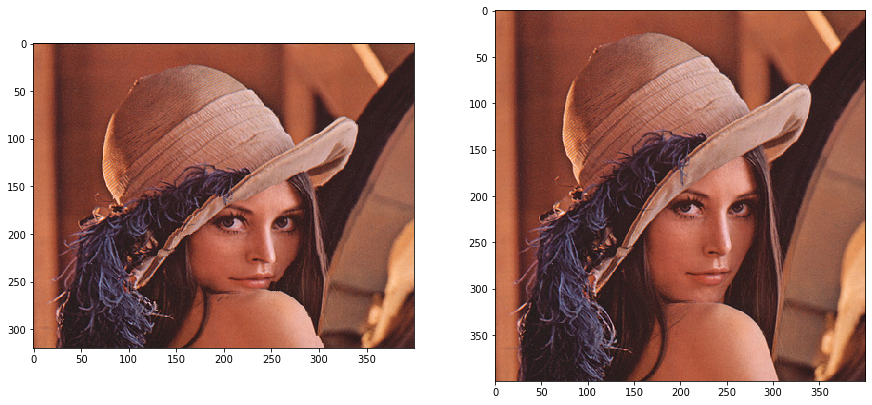

In [7]:
%%time

#seam cavin
sc = find_seam(imh,80,0)

plt.figure(figsize=(15,15))
plt.subplot(221),plt.imshow(sc);
#plt.title('resize')
plt.subplot(222),plt.imshow(imh);

In [8]:
sc.shape, imh.shape

((320, 400, 3), (400, 400, 3))

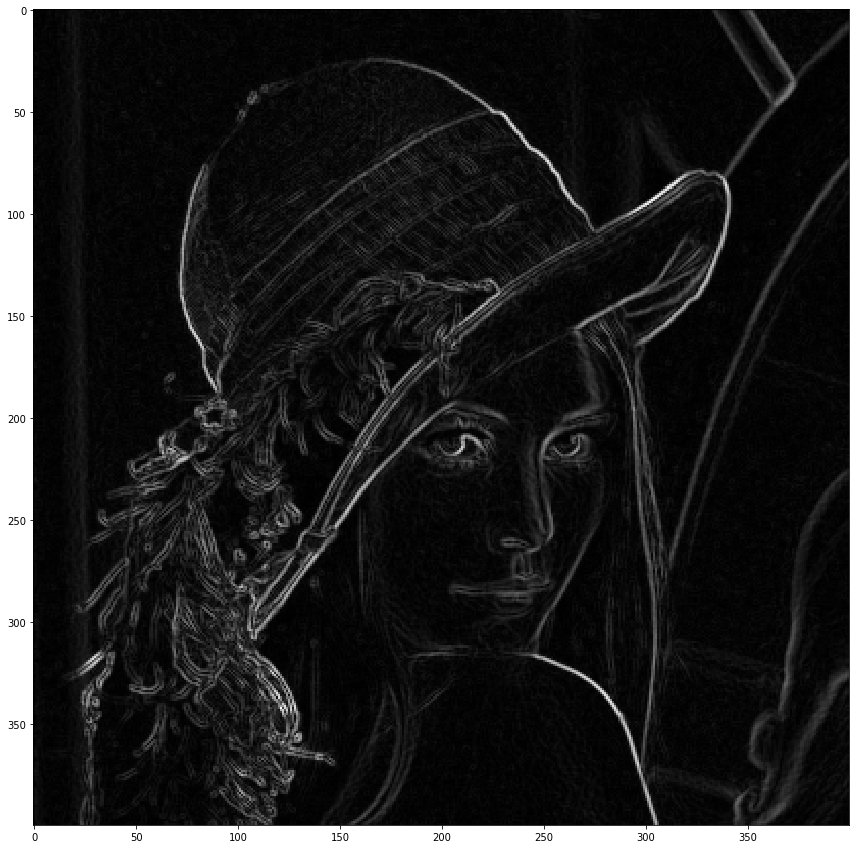

In [9]:
plt.figure(figsize=(15,15))
plt.imshow(calc_energy(imh),'gray')